## Wavelet convolutions

What does a wavelet convolution look like? Lets find out

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt

## Learnable scattering modules
from learnable_wavelets.scattering import create_filters
from learnable_wavelets.scattering import torch_backend

/mnt/home/cpedersen/miniconda3/envs/wavelet_new/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


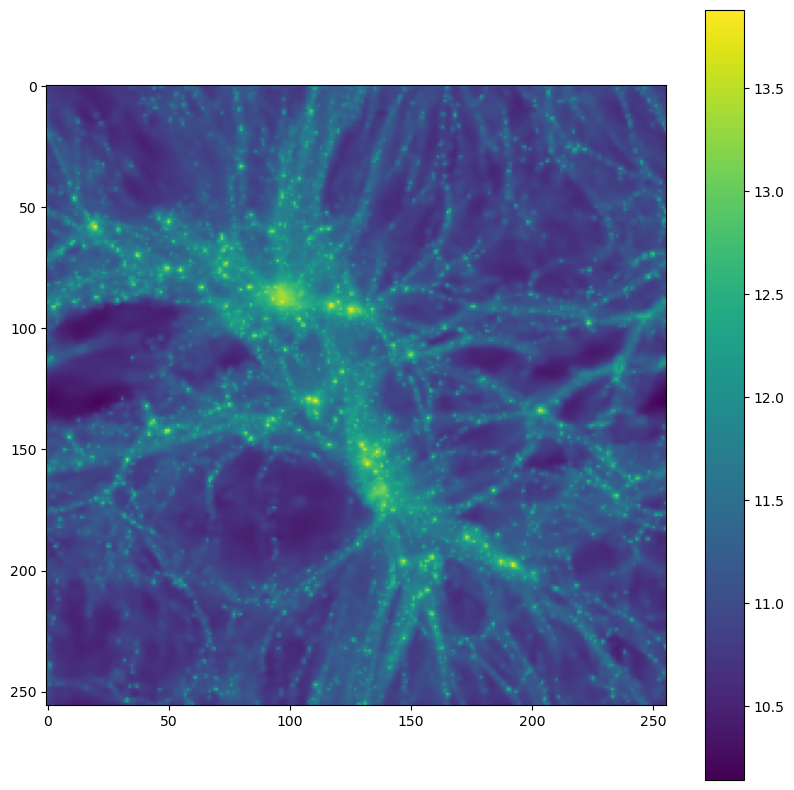

In [2]:
## Load and plot a random map
maps = np.load("../test_data/maps_Mtot_1k.npy")
maps=maps[np.random.randint(len(maps))]

plt.figure(figsize=(10,10))
plt.imshow(np.log10(maps))
plt.colorbar()

In [3]:
phi = create_filters.get_phis(256,256,2)
backend=torch_backend.backend

def convolve_field(camels_map,wavelet,phi,backend):
    x=torch.tensor(maps)

    ## Map to complex
    complex_maps = x.new_zeros(x.shape + (2,))
    complex_maps[..., 0] = x

    U_0_c = backend.fft(complex_maps, 'C2C')

    # First low pass filter
    U_1_c = backend.cdgmm(U_0_c, phi[0])
    U_1_c = backend.subsample_fourier(U_1_c, k=2)


    S_0 = backend.fft(U_1_c, 'C2R', inverse=True)
    
    U_1_c = backend.cdgmm(U_0_c, morlets[0])

    U_1_c = backend.fft(U_1_c, 'C2C', inverse=True)
    U_1_c = backend.modulus(U_1_c)
    U_1_c = backend.fft(U_1_c, 'C2C')

    ## Second low pass filter
    S_1_c = backend.cdgmm(U_1_c, phi[0])
    S_1_c = backend.subsample_fourier(S_1_c, k=2)

    S_1_r = backend.fft(S_1_c, 'C2R', inverse=True)
    
    return S_0, S_1_r

In [11]:
## Generate a wavelet
orientation=[0.8]  ## Orientation
xi=[0.5]           ## Spatial frequency
sigma=[2]         ## Size of Gaussian envelope
slant=[0.5]        ## Aspect ratio

morlets=create_filters.morlets((256,256), torch.tensor(orientation), torch.tensor(xi),torch.tensor(sigma), torch.tensor(slant), device="cpu")

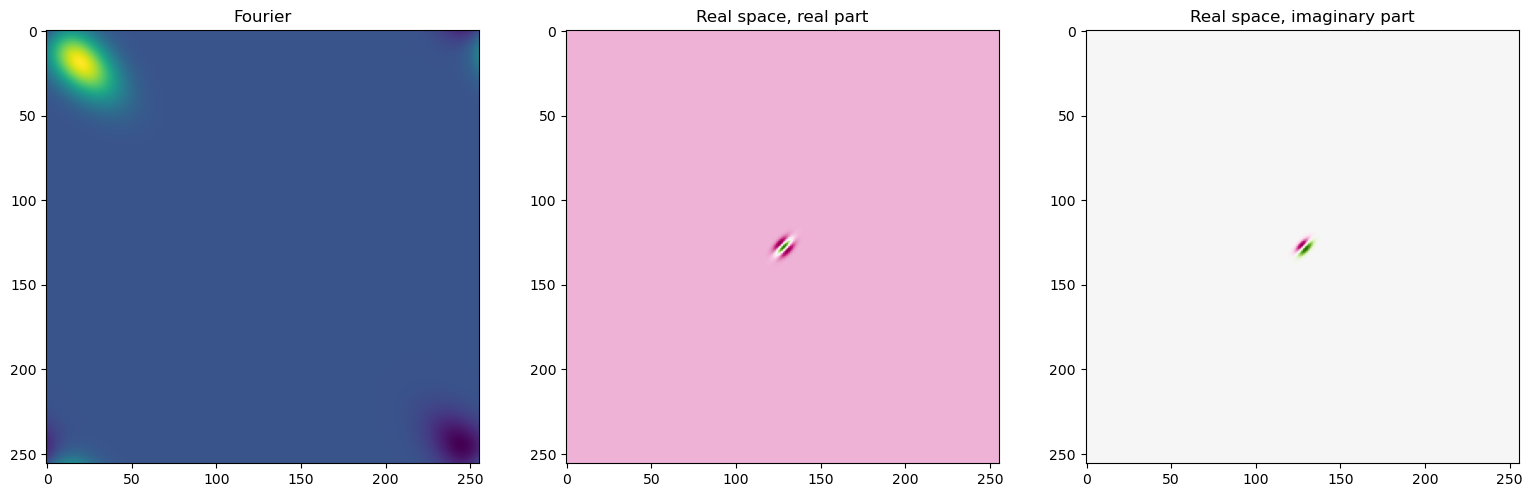

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 7))
ax1.imshow(morlets[0].squeeze())
ax1.title.set_text('Fourier')
ax2.imshow(np.fft.fftshift(np.fft.ifft2(morlets[0].squeeze().numpy())).real,cmap="PiYG")
ax2.title.set_text('Real space, real part')
ax3.imshow(np.fft.fftshift(np.fft.ifft2(morlets[0].squeeze().numpy())).imag,cmap="PiYG")
ax3.title.set_text('Real space, imaginary part')

In [13]:
smoothed,convolved=convolve_field(maps,morlets,phi,backend)

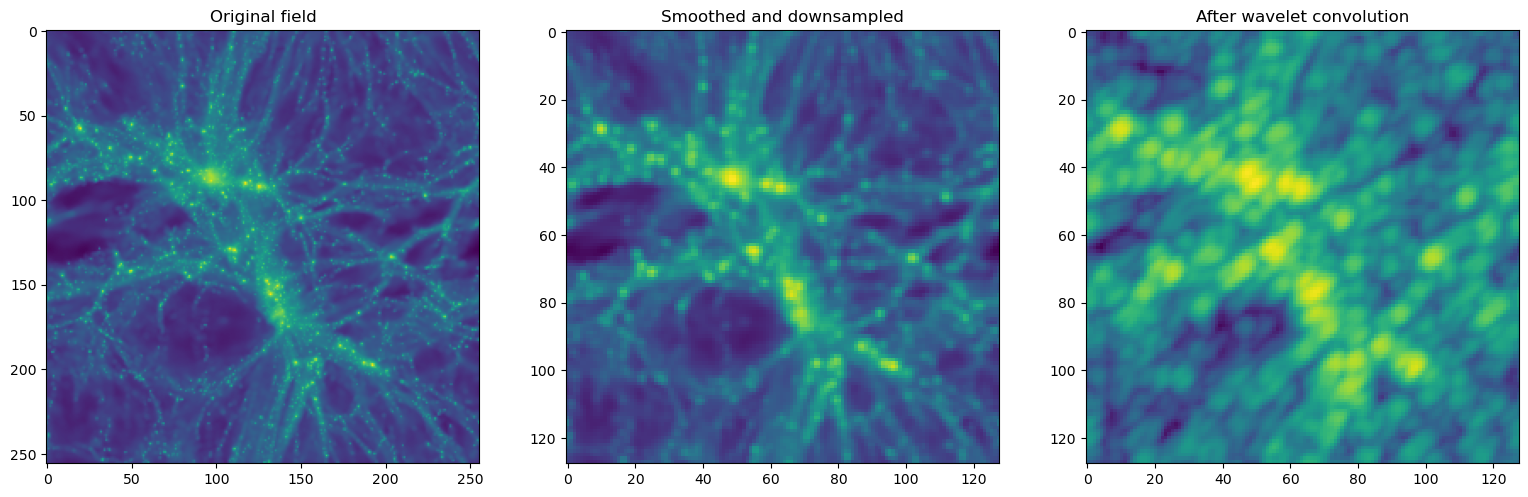

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 7))
ax1.imshow(np.log10(maps))
ax1.title.set_text('Original field')
ax2.imshow(np.log10(smoothed))
ax2.title.set_text('Smoothed and downsampled')
ax3.imshow(np.log10(convolved))
ax3.title.set_text('After wavelet convolution')